### For X_train, y_train, X_test, y_test

In [31]:
%cd HAR
%run MakeDataset.py
%cd ..

import numpy as np
Xtr_raw = np.array(X_train)   
ytr_raw = np.array(y_train)   
Xte_raw = np.array(X_test)    
yte_raw = np.array(y_test)    

print("RAW shapes:", Xtr_raw.shape, ytr_raw.shape, Xte_raw.shape, yte_raw.shape)


[WinError 2] The system cannot find the file specified: 'HAR'
d:\Onedrive\OneDrive - iitgn.ac.in\Desktop\HAR-Recognition\HAR
Training data shape:  (126, 500, 3)
Testing data shape:  (54, 500, 3)
d:\Onedrive\OneDrive - iitgn.ac.in\Desktop\HAR-Recognition
RAW shapes: (126, 500, 3) (126,) (54, 500, 3) (54,)


### Training and evaluate a Decision Tree on the RAW accelerometer windows

X_train: (126, 500, 3) X_test: (54, 500, 3)
Accuracy:  0.5926
Precision: 0.5889
Recall:    0.5926

Classification report:
               precision    recall  f1-score   support

           1       0.27      0.33      0.30         9
           2       0.45      0.56      0.50         9
           3       0.33      0.11      0.17         9
           4       0.62      0.89      0.73         9
           5       0.86      0.67      0.75         9
           6       1.00      1.00      1.00         9

    accuracy                           0.59        54
   macro avg       0.59      0.59      0.57        54
weighted avg       0.59      0.59      0.57        54



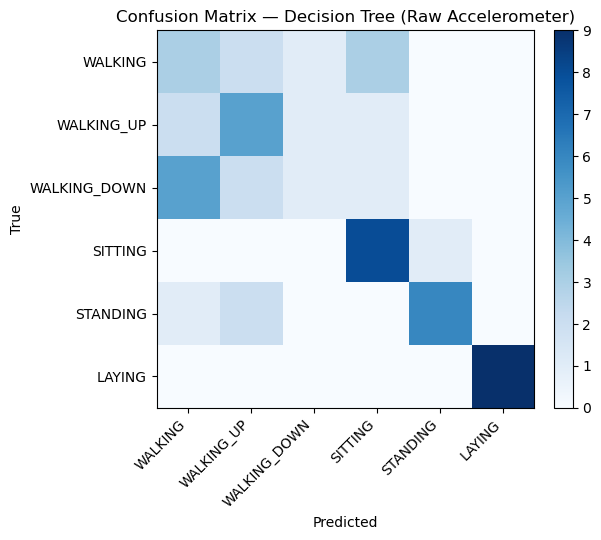

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report


print("X_train:", X_train.shape, "X_test:", X_test.shape)

# Flatten (500×3 → 1500 features)
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)

# Train Decision Tree 
clf = DecisionTreeClassifier(max_depth=6, random_state=0)
clf.fit(X_train_flat, y_train)

# Predict
y_pred = clf.predict(X_test_flat)

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix
labels = [1,2,3,4,5,6]
label_names = {
    1:"WALKING", 2:"WALKING_UP", 3:"WALKING_DOWN",
    4:"SITTING", 5:"STANDING",   6:"LAYING"
}
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6.5,5.5))
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels([label_names[i] for i in labels], rotation=45, ha="right")
ax.set_yticklabels([label_names[i] for i in labels])
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix — Decision Tree (Raw Accelerometer)")
plt.tight_layout()
plt.show()


### Extracting TSFEL features (per axis), anf then training and evaluating a Decision Tree

TSFEL shapes: (126, 468) (54, 468)
Accuracy:  0.8704
Precision: 0.8758
Recall:    0.8704

Classification report:
               precision    recall  f1-score   support

           1       0.88      0.78      0.82         9
           2       0.73      0.89      0.80         9
           3       0.88      0.78      0.82         9
           4       0.89      0.89      0.89         9
           5       0.89      0.89      0.89         9
           6       1.00      1.00      1.00         9

    accuracy                           0.87        54
   macro avg       0.88      0.87      0.87        54
weighted avg       0.88      0.87      0.87        54



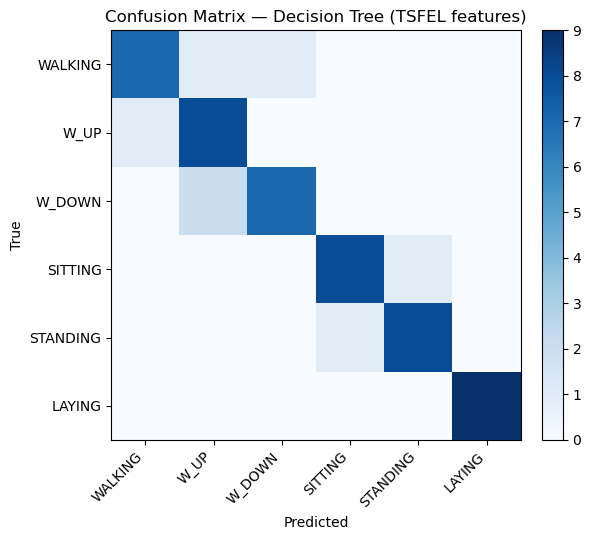

In [33]:
from sklearn.preprocessing import StandardScaler
import tsfel

# --- TSFEL feature extraction helpers ---

cfg = tsfel.get_features_by_domain()

def extract_tsfel_features(X, fs=50):
    """
    X: (N, 500, 3) accelerometer windows
    Returns: (N, F) feature matrix (x|y|z features concatenated)
    """
    feat_rows = []
    for i in range(X.shape[0]):          # loop over each window
        feats = []
        for ax in range(3):              # x,y,z axis
            sig = X[i, :, ax]            # shape (500,)
            df_ax = tsfel.time_series_features_extractor(cfg,
                                                         sig,
                                                         fs=fs,
                                                         verbose=0)
            feats.append(df_ax.values.flatten())
        feat_rows.append(np.hstack(feats))
    F = np.vstack(feat_rows)
    F = np.nan_to_num(F, nan=0.0, posinf=0.0, neginf=0.0)
    return F

# extraction
X_train_tsfel = extract_tsfel_features(X_train)
X_test_tsfel  = extract_tsfel_features(X_test)

print("TSFEL shapes:", X_train_tsfel.shape, X_test_tsfel.shape)


# standardize features before tree
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_tsfel)
X_test_s  = scaler.transform(X_test_tsfel)

# Train Decision Tree on TSFEL features
clf = DecisionTreeClassifier(max_depth=6, random_state=0)
clf.fit(X_train_s, y_train)
y_pred = clf.predict(X_test_s)

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix plot
labels = [1,2,3,4,5,6]
label_names = {
    1:"WALKING", 2:"W_UP", 3:"W_DOWN",
    4:"SITTING", 5:"STANDING", 6:"LAYING"
}
cm = confusion_matrix(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(6.5,5.5))
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels([label_names[i] for i in labels], rotation=45, ha="right")
ax.set_yticklabels([label_names[i] for i in labels])
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix — Decision Tree (TSFEL features)")
plt.tight_layout()
plt.show()


### Training a decision tree model using the features provided in the dataset

C:\Users\yugde\AppData\Local\Temp\ipykernel_32008\2947234893.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Xtr_feat = pd.read_csv(Xtr_path, delim_whitespace=True, header=None)
C:\Users\yugde\AppData\Local\Temp\ipykernel_32008\2947234893.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ytr_feat = pd.read_csv(ytr_path, delim_whitespace=True, header=None).values.ravel()
C:\Users\yugde\AppData\Local\Temp\ipykernel_32008\2947234893.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Xte_feat = pd.read_csv(Xte_path, delim_whitespace=True, header=None)
C:\Users\yugde\AppData\Local\Temp\ipykernel_32008\2947234893.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated

Provided feature shapes: (7352, 561) (2947, 561)
Accuracy:  0.8551
Precision (macro): 0.8577
Recall (macro):    0.8502

Classification report:
               precision    recall  f1-score   support

           1       0.86      0.93      0.90       496
           2       0.87      0.73      0.79       471
           3       0.75      0.82      0.79       420
           4       0.89      0.70      0.78       491
           5       0.77      0.92      0.84       532
           6       1.00      1.00      1.00       537

    accuracy                           0.86      2947
   macro avg       0.86      0.85      0.85      2947
weighted avg       0.86      0.86      0.85      2947



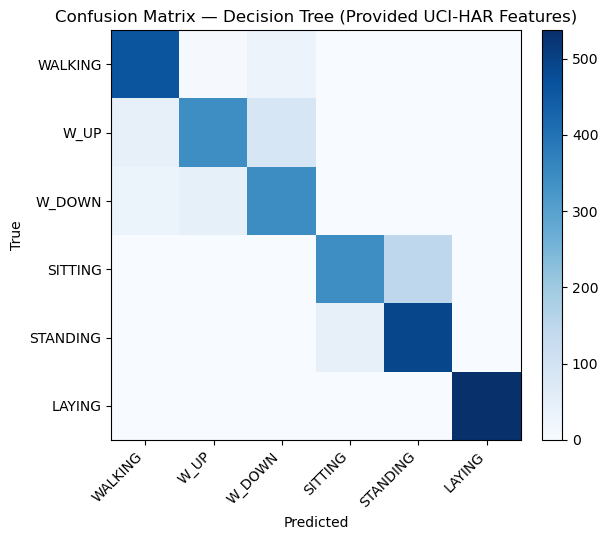

In [38]:
base = Path(r"d:\Onedrive\OneDrive - iitgn.ac.in\Desktop\HAR-Recognition\HAR\UCI HAR Dataset")

# file paths
Xtr_path = base / "train" / "X_train.txt"
ytr_path = base / "train" / "y_train.txt"
Xte_path = base / "test"  / "X_test.txt"
yte_path = base / "test"  / "y_test.txt"

# load 561-d feature matrices and labels (keep separate names)
Xtr_feat = pd.read_csv(Xtr_path, delim_whitespace=True, header=None)
ytr_feat = pd.read_csv(ytr_path, delim_whitespace=True, header=None).values.ravel()
Xte_feat = pd.read_csv(Xte_path, delim_whitespace=True, header=None)
yte_feat = pd.read_csv(yte_path, delim_whitespace=True, header=None).values.ravel()

print("Provided feature shapes:", Xtr_feat.shape, Xte_feat.shape)  # expect (7352, 561) and (2947, 561)

# scale
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr_feat)
Xte_s = scaler.transform(Xte_feat)

# train decision tree
clf = DecisionTreeClassifier(max_depth=6, random_state=0)
clf.fit(Xtr_s, ytr_feat)
yp = clf.predict(Xte_s)

# metrics
acc  = accuracy_score(yte_feat, yp)
prec = precision_score(yte_feat, yp, average="macro", zero_division=0)
rec  = recall_score(yte_feat, yp, average="macro", zero_division=0)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision (macro): {prec:.4f}")
print(f"Recall (macro):    {rec:.4f}\n")
print("Classification report:\n", classification_report(yte_feat, yp, zero_division=0))

# confusion matrix
labels = [1,2,3,4,5,6]
names = {1:"WALKING", 2:"W_UP", 3:"W_DOWN", 4:"SITTING", 5:"STANDING", 6:"LAYING"}
cm = confusion_matrix(yte_feat, yp, labels=labels)

plt.figure(figsize=(6.5,5.5))
im = plt.imshow(cm, cmap="Blues")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(labels)), [names[i] for i in labels], rotation=45, ha="right")
plt.yticks(range(len(labels)), [names[i] for i in labels])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix — Decision Tree (Provided UCI-HAR Features)")
plt.tight_layout(); plt.show()

### Question  
Compare the results of the three models. Which model do you think is better?

The **TSFEL feature-based model** is the best, with ~87% accuracy, precision, and recall.  
It clearly outperforms both the **raw accelerometer model (~59%)** and even the **provided UCI-HAR features (~86%)**,  
making it the most reliable approach.


### Varying depth of decision Tree on all three above models

Varying depths of decision tree model to train and evaluate on raw accelerometer data 

Flattened shapes: (126, 1500) (54, 1500)
depth=2: accuracy=0.4259, precision=0.3081, recall=0.4259
depth=3: accuracy=0.5370, precision=0.3990, recall=0.5370
depth=4: accuracy=0.5926, precision=0.6596, recall=0.5926
depth=5: accuracy=0.5741, precision=0.5709, recall=0.5741
depth=6: accuracy=0.5926, precision=0.5889, recall=0.5926
depth=7: accuracy=0.5741, precision=0.5817, recall=0.5741
depth=8: accuracy=0.5926, precision=0.5949, recall=0.5926


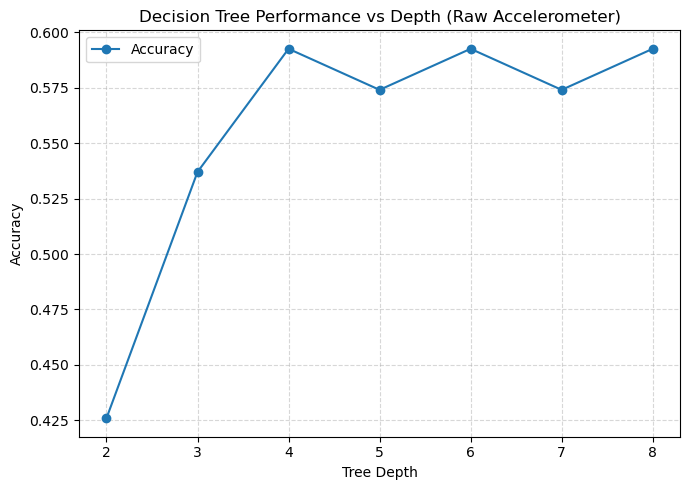

In [41]:
# Flatten windows: (N, 500, 3) -> (N, 1500)
X_train_np = np.array(X_train)
X_test_np  = np.array(X_test)

# Flatten (500×3 → 1500 features) only if 3D
if X_train_np.ndim == 3:
    X_train_flat = X_train_np.reshape(len(X_train_np), -1)
    X_test_flat  = X_test_np.reshape(len(X_test_np), -1)
else:
    X_train_flat = X_train_np
    X_test_flat  = X_test_np

print("Flattened shapes:", X_train_flat.shape, X_test_flat.shape)

depths = list(range(2, 9))  # 2–8
accs, precs, recs = [], [], []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=0)
    clf.fit(X_train_flat, y_train)
    y_pred = clf.predict(X_test_flat)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)

    accs.append(acc)
    precs.append(prec)
    recs.append(rec)

    print(f"depth={d}: accuracy={acc:.4f}, precision={prec:.4f}, recall={rec:.4f}")

# Plot all three vs depth
plt.figure(figsize=(7,5))
plt.plot(depths, accs, marker='o', label="Accuracy")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree Performance vs Depth (Raw Accelerometer)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Varying depths of decision tree model using the features obtained by TSFEL

TSFEL shapes: (126, 468) (54, 468)
TSFEL | depth=2: acc=0.5000, prec=0.3056, rec=0.5000
TSFEL | depth=3: acc=0.7407, prec=0.6929, rec=0.7407
TSFEL | depth=4: acc=0.8519, prec=0.8567, rec=0.8519
TSFEL | depth=5: acc=0.8704, prec=0.8758, rec=0.8704
TSFEL | depth=6: acc=0.8704, prec=0.8758, rec=0.8704
TSFEL | depth=7: acc=0.8704, prec=0.8758, rec=0.8704
TSFEL | depth=8: acc=0.8704, prec=0.8758, rec=0.8704


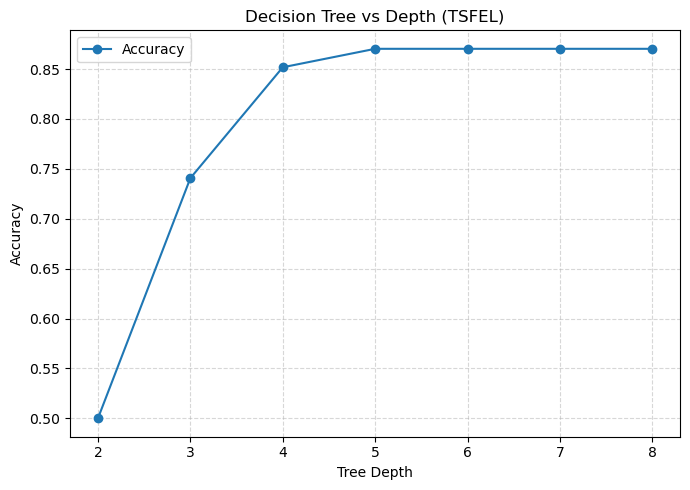

In [46]:
cfg = tsfel.get_features_by_domain()

def extract_tsfel_features(X, fs=50):
    """
    X: (N, 500, 3) accelerometer windows
    Returns: (N, F) matrix; features for x,y,z concatenated
    """
    # ensure numpy array
    X = np.asarray(X)
    if X.ndim != 3 or X.shape[1:] != (500, 3):
        raise ValueError(f"Expected X of shape (N, 500, 3), got {X.shape}. "
                         "You probably overwrote X_* with the 561-feature DataFrame.")
    rows = []
    for i in range(X.shape[0]):
        feats = []
        for ax in range(3):
            sig = X[i, :, ax]              # (500,)
            df_ax = tsfel.time_series_features_extractor(cfg, sig, fs=50, verbose=0)
            feats.append(df_ax.values.flatten())
        rows.append(np.hstack(feats))
    F = np.vstack(rows)
    return np.nan_to_num(F, nan=0.0, posinf=0.0, neginf=0.0)

# Extract on RAW windows
X_train_tsfel = extract_tsfel_features(Xtr_raw)
X_test_tsfel  = extract_tsfel_features(Xte_raw)
print("TSFEL shapes:", X_train_tsfel.shape, X_test_tsfel.shape)

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_tsfel)
X_test_s  = scaler.transform(X_test_tsfel)

# Depth sweep
depths = list(range(2, 9))
accs, precs, recs, clfs = [], [], [], []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=0)
    clf.fit(X_train_s, ytr_raw)                 # <-- correct labels
    y_pred = clf.predict(X_test_s)

    acc  = accuracy_score(yte_raw, y_pred)      # <-- correct test labels
    prec = precision_score(yte_raw, y_pred, average="macro", zero_division=0)
    rec  = recall_score(yte_raw, y_pred, average="macro", zero_division=0)

    accs.append(acc); precs.append(prec); recs.append(rec); clfs.append((clf, y_pred))
    print(f"TSFEL | depth={d}: acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}")

# Plot metrics vs depth
plt.figure(figsize=(7,5))
plt.plot(depths, accs,  marker='o', label="Accuracy")
plt.xlabel("Tree Depth"); plt.ylabel("Accuracy"); plt.title("Decision Tree vs Depth (TSFEL)")
plt.grid(True, linestyle="--", alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()



Varying depth of decision tree model to train using the features provided in the dataset

C:\Users\yugde\AppData\Local\Temp\ipykernel_32008\3957521709.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Xtr_feat = pd.read_csv(Xtr_path, delim_whitespace=True, header=None)
C:\Users\yugde\AppData\Local\Temp\ipykernel_32008\3957521709.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ytr_feat = pd.read_csv(ytr_path, delim_whitespace=True, header=None).values.ravel()
C:\Users\yugde\AppData\Local\Temp\ipykernel_32008\3957521709.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Xte_feat = pd.read_csv(Xte_path, delim_whitespace=True, header=None)
C:\Users\yugde\AppData\Local\Temp\ipykernel_32008\3957521709.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated

Provided feature shapes: (7352, 561) (2947, 561)
Provided feature | depth=2: acc=0.5310, prec=0.3129, rec=0.5000
Provided feature | depth=3: acc=0.7224, prec=0.6660, rec=0.7105
Provided feature | depth=4: acc=0.8096, prec=0.8254, rec=0.8017
Provided feature | depth=5: acc=0.8385, prec=0.8466, rec=0.8313
Provided feature | depth=6: acc=0.8551, prec=0.8577, rec=0.8502
Provided feature | depth=7: acc=0.8639, prec=0.8641, rec=0.8605
Provided feature | depth=8: acc=0.8707, prec=0.8727, rec=0.8663


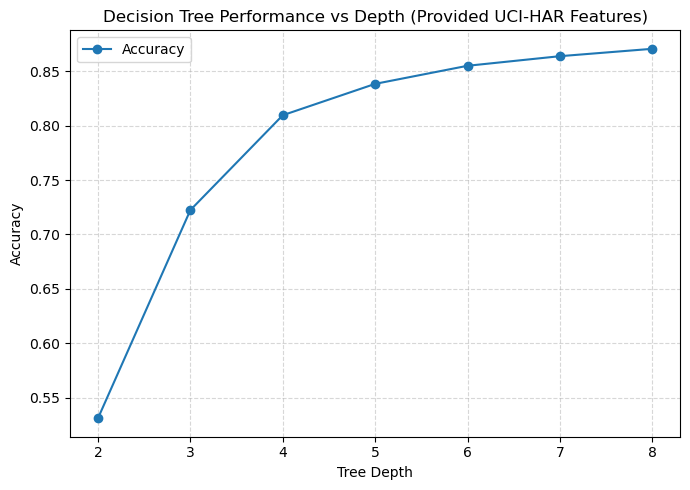

In [47]:
base = Path(r"d:\Onedrive\OneDrive - iitgn.ac.in\Desktop\HAR-Recognition\HAR\UCI HAR Dataset")

# file paths
Xtr_path = base / "train" / "X_train.txt"
ytr_path = base / "train" / "y_train.txt"
Xte_path = base / "test"  / "X_test.txt"
yte_path = base / "test"  / "y_test.txt"

# load provided 561-d feature matrices
Xtr_feat = pd.read_csv(Xtr_path, delim_whitespace=True, header=None)
ytr_feat = pd.read_csv(ytr_path, delim_whitespace=True, header=None).values.ravel()
Xte_feat = pd.read_csv(Xte_path, delim_whitespace=True, header=None)
yte_feat = pd.read_csv(yte_path, delim_whitespace=True, header=None).values.ravel()

print("Provided feature shapes:", Xtr_feat.shape, Xte_feat.shape)

# scale
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr_feat)
Xte_s = scaler.transform(Xte_feat)

# --- Depth sweep (2–8) ---
depths = list(range(2, 9))
accs, precs, recs, clfs = [], [], [], []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=0)
    clf.fit(Xtr_s, ytr_feat)
    yp = clf.predict(Xte_s)

    acc  = accuracy_score(yte_feat, yp)
    prec = precision_score(yte_feat, yp, average="macro", zero_division=0)
    rec  = recall_score(yte_feat, yp, average="macro", zero_division=0)

    accs.append(acc); precs.append(prec); recs.append(rec); clfs.append((clf, yp))
    print(f"Provided feature | depth={d}: acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}")

# --- Plot Accuracy/Precision/Recall vs depth ---
plt.figure(figsize=(7,5))
plt.plot(depths, accs,  marker='o', label="Accuracy")
plt.xlabel("Tree Depth"); plt.ylabel("Accuracy")
plt.title("Decision Tree Performance vs Depth (Provided UCI-HAR Features)")
plt.grid(True, linestyle="--", alpha=0.5); plt.legend()
plt.tight_layout(); plt.show()




### Question  
Are there any participants/activities where the model performance is bad? If Yes, Why?

### Answer  
Yes, there are certain activities where the model performance is weaker compared to others, especially when using the **raw accelerometer data**.

1. **Raw Accelerometer Data (Worst Performance)**  
   - The accuracy peaks around **59%**, with precision and recall fluctuating in the 0.57–0.59 range.  
   - This poor performance arises because raw accelerometer signals are **high-dimensional (1500 features per sample)** and noisy.  
   - Without feature extraction, the decision tree struggles to capture meaningful patterns, leading to confusion between activities that have similar motion profiles (e.g., **Walking vs Walking Up/Down stairs**).

2. **TSFEL Features (Best Performance on Small Dataset)**  
   - With TSFEL, accuracy improves to about **87%**, with balanced precision and recall.  
   - By extracting **time-series features (mean, variance, entropy, etc.)**, the model better distinguishes activities.  
   - However, even at this level, some activities like **Sitting vs Standing** can remain challenging, since the accelerometer readings in stationary positions are very similar.

3. **Provided UCI-HAR Features (Large Dataset, Strong Performance)**  
   - Accuracy reaches **~87% at depth=8**, with precision and recall both above 0.86.  
   - The larger training dataset (7352 samples) and the engineered features provided in UCI-HAR allow the tree to generalize better.  
   - Still, minor misclassifications occur for activities with **overlapping movement dynamics**, again most notably **Walking-related activities** and **static postures**.

---

### Why Performance Is Bad in Certain Cases  
- **Ambiguity in sensor data:** Activities such as **Walking Up vs Walking Down** stairs have very similar acceleration profiles, making them hard to separate.  
- **Stationary activities:** **Sitting vs Standing** often overlap in accelerometer magnitude, since both are nearly motionless.  
- **Model limitations:** A decision tree alone cannot capture complex temporal patterns present in raw signals; it benefits greatly from engineered features (TSFEL or UCI-HAR).  
- **Dataset size:** With only **126 training samples** in the raw/TSFEL splits, the model is prone to overfitting and lacks generalization compared to the full UCI-HAR dataset.

---

### Conclusion  
The **worst performance** is seen with **raw accelerometer inputs**, due to noise and lack of informative features.  
The **best performance** comes from **TSFEL and UCI-HAR feature-based inputs**, both reaching ~87% accuracy.  
Thus, feature extraction (either handcrafted like TSFEL or provided in UCI-HAR) is **essential for distinguishing confusing activities** such as **Walking variations** and **Sitting vs Standing**.
